# Обработка шумов самолётов

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Clou_TXL_aircraft_05.jpg/640px-Clou_TXL_aircraft_05.jpg "A.Savin")

Имеется выборка значений максимальных уровней шума самолётов (значения в дБА). В окрестности точки замеров самолёты летают в нескольких разных режимах, производящих разные уровни шума. На основании предоставленных данных требуется:

1. Оценить тип математического распределения представленных значений и его параметры;
2. Предложить алгоритм, который будет различать режимы и прогонозировать, в каком режиме пролетел самолёт;
3. Оценить достоверность прогнозов этого алгоритма;
4. Сделать выводы о физическом смысле обнаруженных закономерностей; какие реальные обстоятельства могут приводить к появлению именно такого шума.
5. Какие дополнительные данные позволяют улучшить точность прогнозов?

# Список использованных сокращений

* ВПП — взлётно-посадочная полоса;
* дБА — децибел акустический;
* ЛА — летательный аппарат.

## Загрузка и первичное знакомство с данными

In [ ]:
! gdown 11UL2gn8ahI8q1U36GLcjfiaST98VLMJ9

Downloading...
From: https://drive.google.com/uc?id=11UL2gn8ahI8q1U36GLcjfiaST98VLMJ9
To: /content/noise_data_test.csv
100% 416k/416k [00:00<00:00, 75.2MB/s]


In [ ]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.set(rc={'figure.figsize': (15, 7)})
sns.set_style('darkgrid')
sns.set(font_scale=1.2)

In [ ]:
df = pd.read_csv('/content/noise_data_test.csv', index_col=0, parse_dates=[1])

In [ ]:
df.head()

,timestamp,max_slow,type,model
0,2022-03-01 00:03:47,70.800003,B738,Boeing 737-800
1,2022-03-01 00:05:02,69.199997,B738,Boeing 737-800
2,2022-03-01 00:06:24,69.599998,B738,Boeing 737-800
3,2022-03-01 00:09:47,71.500000,B738,Boeing 737-800
4,2022-03-01 00:11:43,70.800003,B738,Boeing 737-800


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6673 entries, 0 to 6672
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  6673 non-null   datetime64[ns]
 1   max_slow   6673 non-null   float64       
 2   type       6673 non-null   object        
 3   model      6673 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 260.7+ KB


In [ ]:
df.describe(datetime_is_numeric=True)

,timestamp,max_slow
count,6673,6673.000000
mean,2022-04-12 22:32:22.562265856,68.477087
min,2022-03-01 00:03:47,50.599998
25%,2022-03-19 20:07:55,65.099998
50%,2022-04-14 11:08:18,68.300003
75%,2022-05-03 01:12:54,72.000000
max,2022-05-29 00:07:10,91.500000
std,NaN,4.509026


In [ ]:
df.duplicated().sum()

0

**Промежуточный вывод**

Нам доступен файл с более чем 6 тысячами записей. Пропусков данных нет, дубликатов данных нет. 

Из описания задачи можно сделать предположения о данных в каждой из колонок:
* `timestamp` — время фиксации шума с точностью до секунды;
* `max_slow` — максимальный уровень шума самолёта (дБА);
* `type` — обозначение типа самолёта, присваиваемое авиалинией;
* `model` — обозначение модели самолёта.

## Исследовательский анализ данных

Познакомимся с данными поближе.

### `timestamp`

In [ ]:
df['timestamp'].describe(datetime_is_numeric=True)

count                             6673
mean     2022-04-12 22:32:22.562265856
min                2022-03-01 00:03:47
25%                2022-03-19 20:07:55
50%                2022-04-14 11:08:18
75%                2022-05-03 01:12:54
max                2022-05-29 00:07:10
Name: timestamp, dtype: object

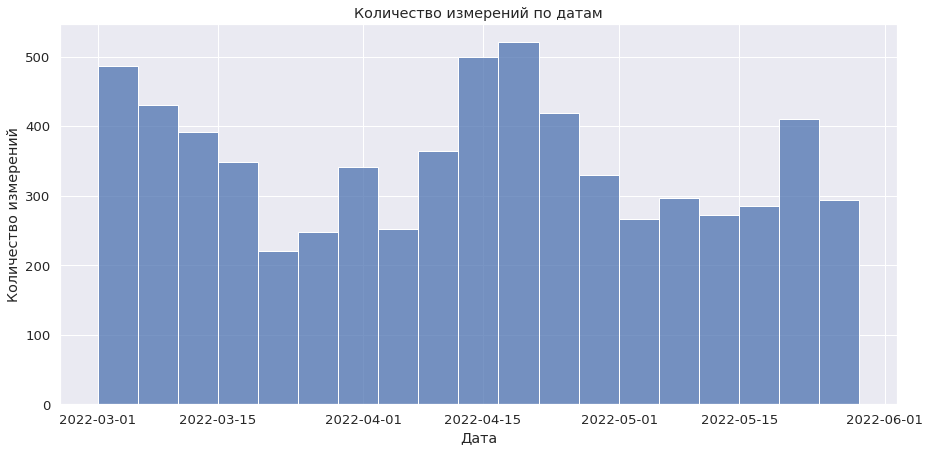

In [ ]:
sns.histplot(data=df, x='timestamp')\
.set(xlabel='Дата',
    ylabel='Количество измерений',
     title='Количество измерений по датам');

Наши данные собирались с первого марта по 29 мая 2022 года. В разные дни собиралось разное количество данных. Отметки времени проставлялись с точностью до секунды.

### `type`

In [ ]:
df['type'].nunique()

46

In [ ]:
df['type'].value_counts().head(7).to_frame()

,type
B738,2668
SU95,834
B735,660
A319,351
A321,197
A320,197
A332,186


In [ ]:
df['type'].value_counts().tail(7).to_frame()

,type
E75L,2
PC12,2
B739,2
E190,1
B789,1
IL76,1
B742,1


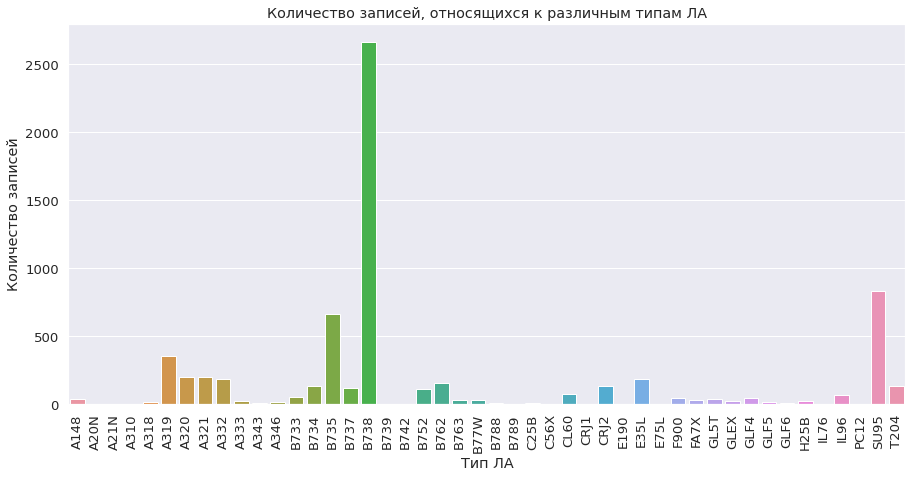

In [ ]:
cpl = sns.countplot(data=df.sort_values(by='type'), x='type')
cpl.set_xticklabels(labels=cpl.get_xticklabels(), rotation=90)
cpl.set(xlabel='Тип ЛА',
       ylabel='Количество записей',
       title='Количество записей, относящихся к различным типам ЛА');

В данных имеются записи о летательных аппаратах 46 различных типов. Больше всего записей (почти 40 процентов) относятся к типу B738. О некоторых самолётах (например, IL76 и E190) записей почти нет. 

Наблюдается дисбаланс данных о типах ЛА. На текущей задаче это скорее всего не скажется, но может быть очень важным при машинном обучении.

### `model`

In [ ]:
df['model'].nunique()

46

In [ ]:
df['model'].value_counts().head(7).to_frame()

,model
Boeing 737-800,2668
Sukhoi Superjet 100-95,834
Boeing 737-500,660
Airbus A319,351
Airbus A321,197
Airbus A320,197
Airbus A330-200,186


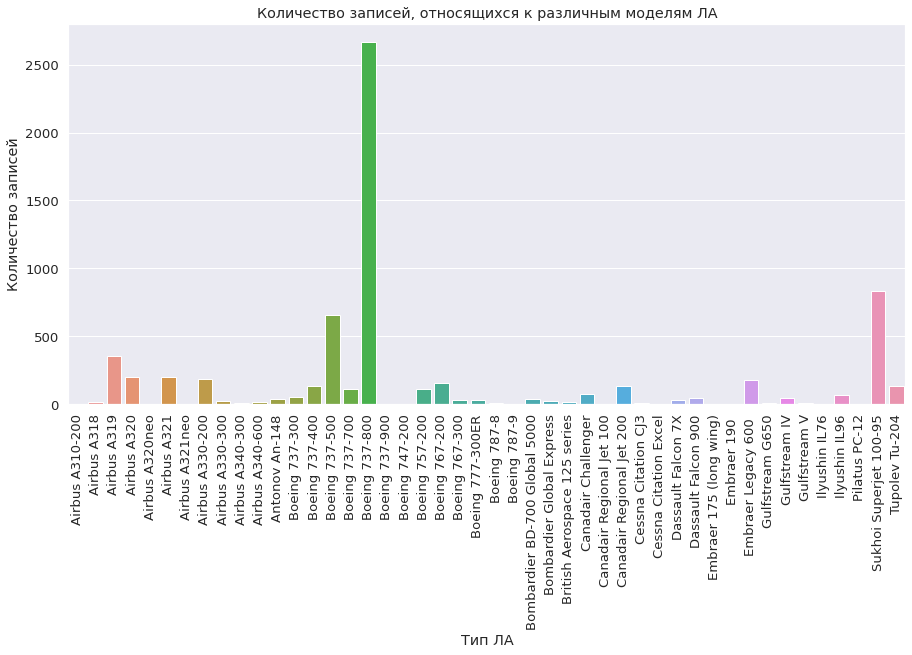

In [ ]:
cpl = sns.countplot(data=df.sort_values(by='model'), x='model')
cpl.set_xticklabels(labels=cpl.get_xticklabels(), rotation=90)
cpl.set(xlabel='Тип ЛА',
       ylabel='Количество записей',
       title='Количество записей, относящихся к различным моделям ЛА');

Данные о модели ЛА дублируют данные о типе. Попробуем посмотреть, какие фирмы-производители самолётов представлены в нашей выборке.

In [ ]:
df['dev_company'] = df['model'].str.split().str.get(0)

In [ ]:
df['dev_company'].nunique()

14

In [ ]:
df['dev_company'].value_counts(normalize=True)

Boeing        0.595085
Airbus        0.149408
Sukhoi        0.124981
Canadair      0.031770
Embraer       0.027574
Tupolev       0.020081
Dassault      0.011989
Ilyushin      0.009891
Gulfstream    0.009741
Bombardier    0.008991
Antonov       0.005994
British       0.002847
Cessna        0.001349
Pilatus       0.000300
Name: dev_company, dtype: float64

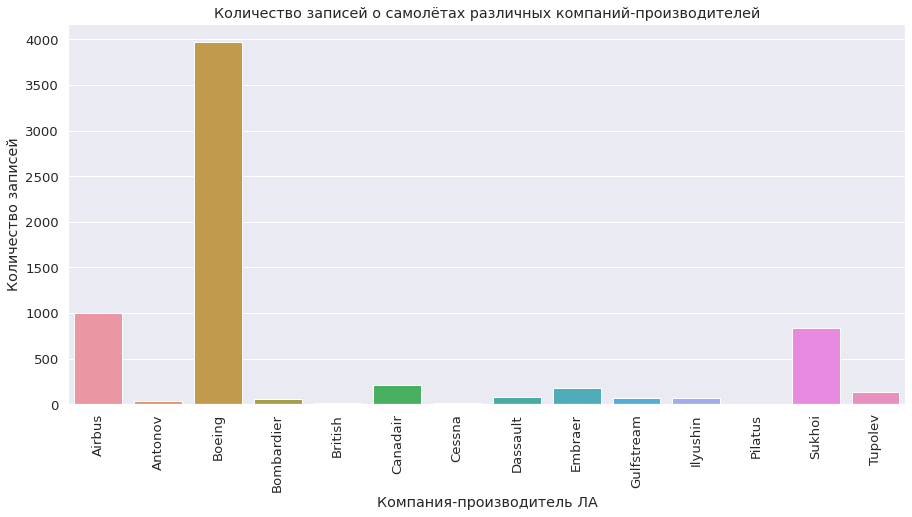

In [ ]:
cpl = sns.countplot(data=df.sort_values(by='dev_company'), x='dev_company')
cpl.set_xticklabels(labels=cpl.get_xticklabels(), rotation=90)
cpl.set(title='Количество записей о самолётах различных компаний-производителей',
    xlabel='Компания-производитель ЛА',
    ylabel='Количество записей');

В нашей выборке представлены самолёт 14 разных производителей. Больше всего данных о самолётах компании Boeing (почти 60 процентов всех записей). Второе место — за компанией Airbus, третье — за Гражданскими самолётами Сухого.

### `max_slow`

In [ ]:
df['max_slow'].describe()

count    6673.000000
mean       68.477087
std         4.509026
min        50.599998
25%        65.099998
50%        68.300003
75%        72.000000
max        91.500000
Name: max_slow, dtype: float64

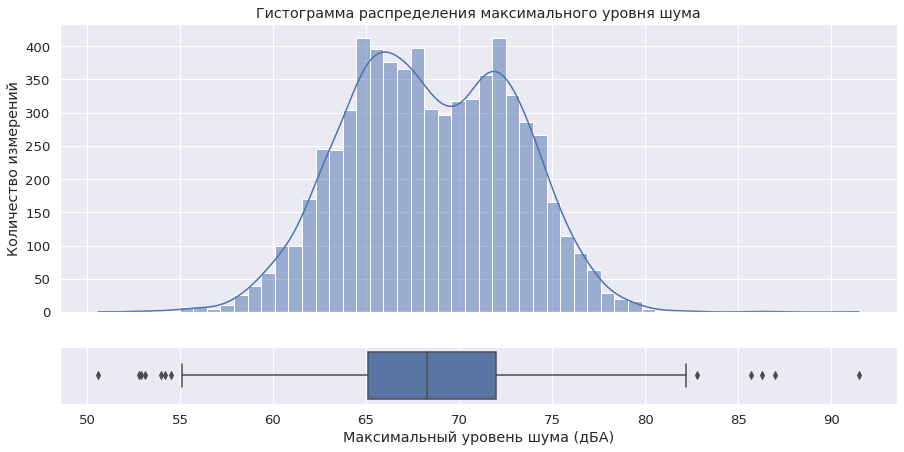

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 7), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=df, x='max_slow', kde=True, ax=axs_hist)
box = sns.boxplot(data=df, x='max_slow', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения максимального уровня шума',
         ylabel='Количество измерений')
box.set(xlabel='Максимальный уровень шума (дБА)');

Распределение ожидаемо отличается от нормального. Среднее — 68 дБА, стандартное отклонение — 4.5. 

В данном случае мы наблюдаем максимальные уровни шумов для различных типов самолётов, для анализа было бы полезно посмотреть на распределения максимального уровня шума для отдельных типов ЛА.

Отберём несколько наиболее часто встречающихся в данных типов ЛА и построим для них гистограммы.

In [ ]:
df.type.value_counts().sort_values(ascending=False).head(5).to_frame()

,type
B738,2668
SU95,834
B735,660
A319,351
A321,197


In [ ]:
b738 = df[df['type'] == 'B738'].copy()

In [ ]:
su95 = df[df['type'] == 'SU95'].copy()

In [ ]:
b735 = df[df['type'] == 'B735'].copy()

In [ ]:
a319 = df[df['type'] == 'A319'].copy()

In [ ]:
a320 = df[df['type'] == 'A320'].copy()

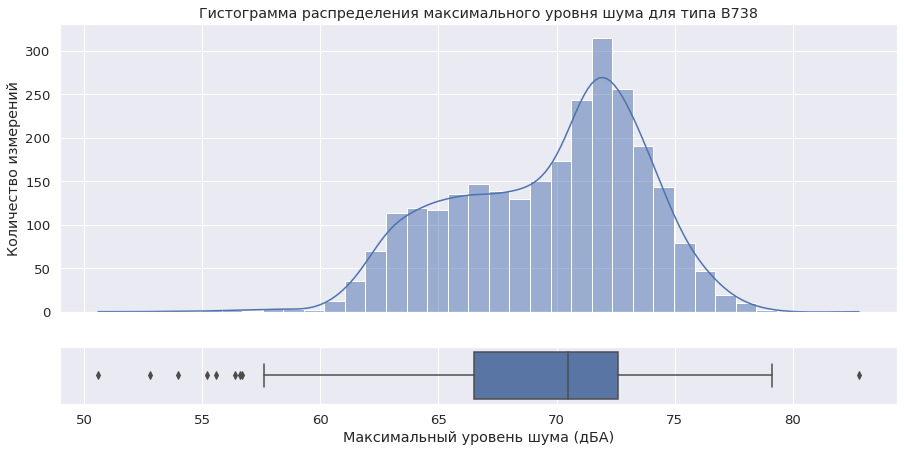

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 7), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=b738, x='max_slow', kde=True, ax=axs_hist)
box = sns.boxplot(data=b738, x='max_slow', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения максимального уровня шума для типа B738',
         ylabel='Количество измерений')
box.set(xlabel='Максимальный уровень шума (дБА)');

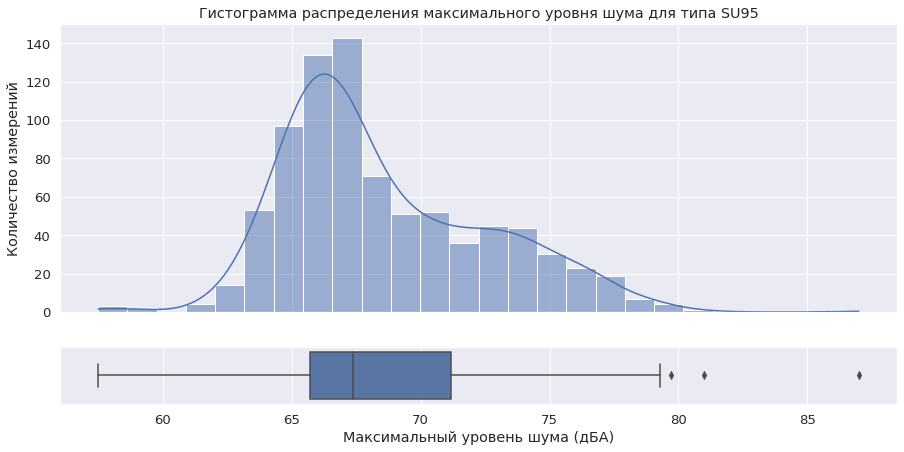

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 7), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=su95, x='max_slow', kde=True, ax=axs_hist)
box = sns.boxplot(data=su95, x='max_slow', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения максимального уровня шума для типа SU95',
         ylabel='Количество измерений')
box.set(xlabel='Максимальный уровень шума (дБА)');

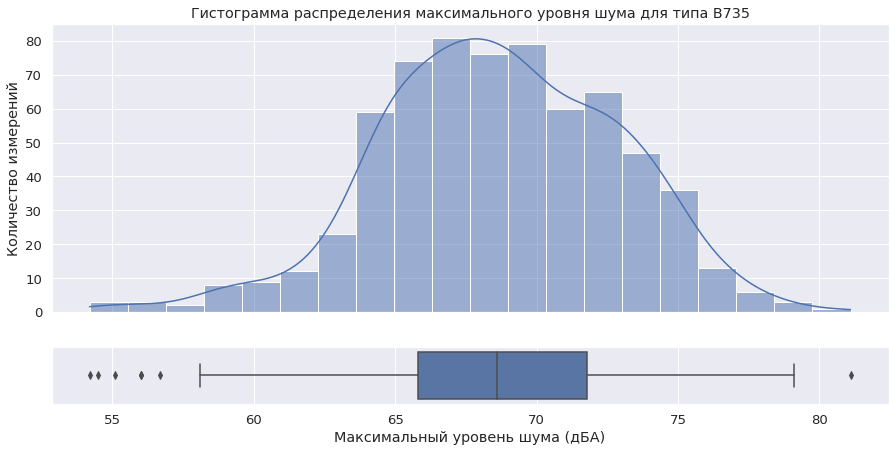

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 7), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=b735, x='max_slow', kde=True, ax=axs_hist)
box = sns.boxplot(data=b735, x='max_slow', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения максимального уровня шума для типа B735',
         ylabel='Количество измерений')
box.set(xlabel='Максимальный уровень шума (дБА)');

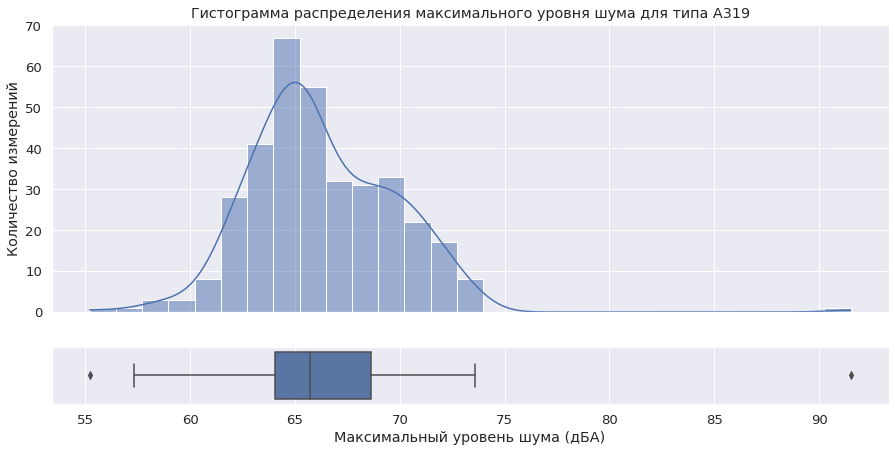

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 7), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=a319, x='max_slow', kde=True, ax=axs_hist)
box = sns.boxplot(data=a319, x='max_slow', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения максимального уровня шума для типа A319',
         ylabel='Количество измерений')
box.set(xlabel='Максимальный уровень шума (дБА)');

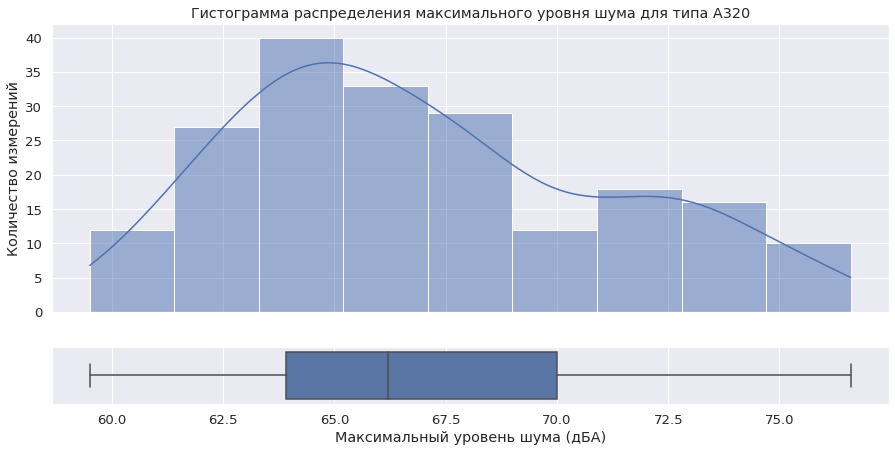

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 7), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=a320, x='max_slow', kde=True, ax=axs_hist)
box = sns.boxplot(data=a320, x='max_slow', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения максимального уровня шума для типа A320',
         ylabel='Количество измерений')
box.set(xlabel='Максимальный уровень шума (дБА)');

На всех гистограммах для отдельных типов ЛА мы наблюдаем интересную картину. Распределение максимального уровня шума заметно отличается от нормального, но похоже на комбинацию из двух нормальных распределений с разными дисперсиями и средними. Например, для типа B738 средние двух распределений могли бы находиться примерно около значений 66 и 73 дБА.

Похоже, что мы наблюдаем те самые режимы, о которых говорилось в задании. Предположим, что во время измерений фиксировался шум взлёта и посадки ЛА и это привело к формированию двух наложившихся друг на друга распределений.

Попробуем проверить нашу гипотезу. Будем исходить из того, что все данные собирались у одного и того же аэропорта и с одной и той же позиции. Можно предположить, что для достаточно продолжительного промежутка времени количество посадок самолётов одного и того же типа будет примерно равно количеству взлётов.

Ещё раз посмотрим на распределение для типа B738.

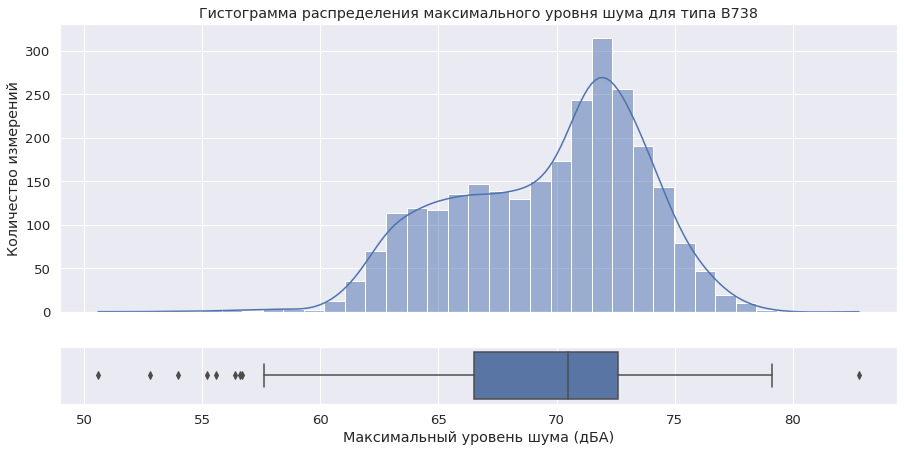

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 7), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=b738, x='max_slow', kde=True, ax=axs_hist)
box = sns.boxplot(data=b738, x='max_slow', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения максимального уровня шума для типа B738',
         ylabel='Количество измерений')
box.set(xlabel='Максимальный уровень шума (дБА)');

Предположим, что оно составлено из двух распределений со средними около значений 66 и 73 дБА.

Основным источником шума в самолёте является двигатель. Режимы работы двигателя при взлёте и посадке существенно различаются по мощности, а значит и по уровню создаваемого шума. Предположим, что распределение со средним около 66 дБА сформировалось при записи посадок, а со средним около 73 дБА — при фиксации взлётов.

Мы не можем точно посчитать число взлётов и посадок, но можем предположить, что распределения максимального уровня шума стремятся к нормальным. Мы не можем «разелить» данные между 66 и 73 дБА на записи взлётов и посадок. Но мы знаем, что нормальные распределения симметричны относительно среднего, а значит, если наша гипотеза верна, число записей с максимальным уровнем шума более 73 дБА будет примерно равно числу записей с максимальным уровнем шума менее 66 дБА. Точного равенства мы не достигнем так как средние мы определили "на глазок", да и распределения не будут идеально симметричными.

Посчитаем число записей с максимальным уровнем шума более 73 дБА:

In [ ]:
(b738['max_slow'] >= 73).sum()

577

И менее 66 дБА:

In [ ]:
(b738['max_slow'] <= 66).sum()

591

Очень неплохо. Для успокоения совести проверим нашу гипотезу для SU95.

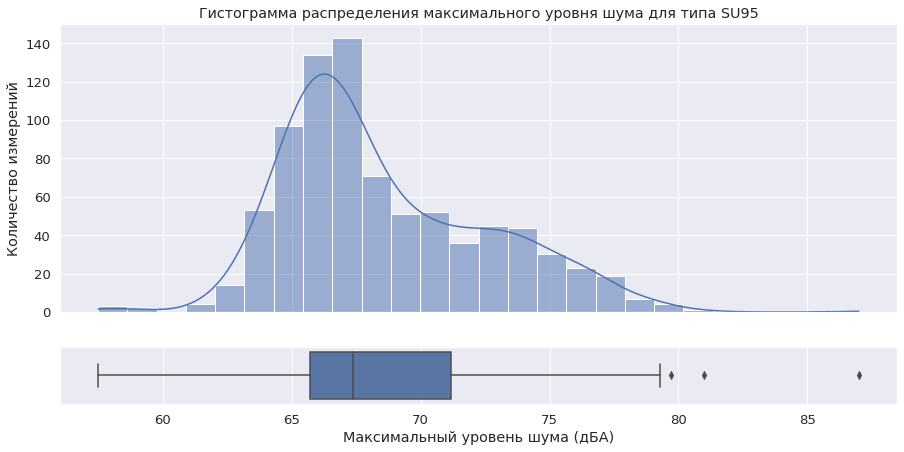

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 7), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=su95, x='max_slow', kde=True, ax=axs_hist)
box = sns.boxplot(data=su95, x='max_slow', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения максимального уровня шума для типа SU95',
         ylabel='Количество измерений')
box.set(xlabel='Максимальный уровень шума (дБА)');

Данных для этого типа ЛА меньше, поэтому предполагаемые распределения заметно оличаются от нормальных. Будем считать, что средние лежат около 66 и 71—72 дБА.

In [ ]:
(su95['max_slow'] >= 71).sum()

219

In [ ]:
(su95['max_slow'] <= 66).sum()

255

Количество предполагаемых взлётов и посадок снова близко.

Будем считать, что у нас нет оснований отвергнуть гипотезу, что в данных содержится информация о максимальных уровнях шума при взлёте и посадке ЛА различных типов.

**Промежуточный вывод**

Мы провели исследовательский анализ данных, в ходе которого установлено, что:

* данные собирались с первого марта по 29 мая 2022 года;
* в разные дни собиралось разное количество данных;
* отметки времени проставлялись с точностью до секунды;
* в данных имеются записи о летательных аппаратах 46 различных типов;
* больше всего записей (почти 40 процентов) относятся к типу B738;
* почти 60 процентов всех записей относятся к самолётам компании Boeing;
* распределение данных в колонке `max_slow` сильно отличается от нормального.

Мы построили отдельные гистограммы распределения данных в колонке `max_slow` для наиболее часто встречающихся типов ЛА. При анализе гистограмм возникла гипотеза, что каждое из наблюдаемых распределений может быть сформировано комбинацией двух близких к нормальному распределений. Подобные данные могли бы наблюдаться при сборе данных о шуме при взлёте и посадке ЛА.

Мы не обладаем достаточной информацией для полноценной проверки данной гипотезы, поэтому ограничились косвенной проверкой: мы посчитали количество записей, располагающихся на гистограмме левее и правее средних предполагаемых распределений. Так как количество данных записей для типов B738 и SU95 достаточно близко, у нас нет оснований для того, чтобы отклонить гипотезу.

# Направление дальнейших работ

Проведённый анализ данных показал, что при записи максимального уровня шума пролетающих ЛА можно попытаться определить режим работы двигателя. Очевидно, что данных только лишь о типе ЛА и уровне шума недостаточно для уверенной классификации (распределения максимального уровня шума при взлёте и посадке накладываются друг на друга).

Попробуем перечислить дополнительные факторы, которые могут влиять на уровень шума:
* взаимное расположение фиксирующей аппаратуры и ВПП (но не только расстояние между ними);
* погодные условия в момент записи (влажность и температура воздуха, ветер, наличие загрязнений в воздухе);
* качество и состояние фиксирующей аппаратуры;
* состояние двигателя ЛА;
* конкретный профиль глиссады;
* и т.д.

Исходя из этого можно попробовать обогатить нашу выборку и построить модель машинного обучения, которая определяла бы режим работы двигателя с учётом всех собраных факторов. При этом следует учесть, что данных о ЛА некоторых типов у нас довольно мало, поэтому для корректной работы модели придётся собирать достаточно большу выборку.

Фактически мы будем решать задачу бинарной классификации по табличным данным. Можно поробовать применить различные модели машинного обучения, например, градиентный бустинг на решающих деревьях. После подбора гипер-параметров и порога классификации можно ожидать достаточно хорошего результата.

# Выводы

В рамках данной задачи у нас имеется выборка значений максимальных уровней шума самолётов (значения в дБА). В окрестности точки замеров самолёты летают в нескольких разных режимах, производящих разные уровни шума. На основании имеющихся данных требовалось:

1. Оценить тип математического распределения представленных значений и его параметры;
2. Предложить алгоритм, который будет различать режимы и прогонозировать, в каком режиме пролетел самолёт;
3. Оценить достоверность прогнозов этого алгоритма;
4. Сделать выводы о физическом смысле обнаруженных закономерностей; какие реальные обстоятельства могут приводить к появлению именно такого шума.
5. Какие дополнительные данные позволяют улучшить точность прогнозов?

В выборке представлены следующие данные:
* `timestamp` — время фиксации шума с точностью до секунды;
* `max_slow` — максимальный уровень шума самолёта (дБА);
* `type` — обозначение типа самолёта, присваиваемое авиалинией;
* `model` — обозначение модели самолёта.

Мы провели исследовательский анализ данных, в ходе которого установлено, что:

* данные собирались с первого марта по 29 мая 2022 года;
* в разные дни собиралось разное количество данных;
* отметки времени проставлялись с точностью до секунды;
* в данных имеются записи о летательных аппаратах 46 различных типов;
* больше всего записей (почти 40 процентов) относятся к типу B738;
* почти 60 процентов всех записей относятся к самолётам компании Boeing;
* распределение данных в колонке `max_slow` сильно отличается от нормального.

Мы также построили отдельные гистограммы распределения данных в колонке `max_slow` для нескольких типов ЛА. При анализе гистограмм возникла гипотеза, что каждое из наблюдаемых распределений может быть сформировано комбинацией двух близких к нормальному распределений. Подобные данные могли наблюдаться при сборе данных о шуме при взлёте и посадке ЛА.

Мы не обладаем достаточной информацией для полноценной проверки данной гипотезы, поэтому ограничились косвенной проверкой: посчитали количество записей, располагающихся на гистограмме левее и правее средних предполагаемых распределений. Так как количество данных записей для типов B738 и SU95 достаточно близко, у нас нет оснований для того, чтобы отклонить гипотезу.

В качестве возможного направления дальнейших работ предлгается разработка модели машинного обучения, предсказывающий режим полёта ЛА по данным о производимом шуме.

Для этого требуется обогатить выборку дополнительными данным, потенциально влияющими на качество прогнозирования.

В качестве примера подобных данных можно привести:

* взаимное расположение фиксирующей аппаратуры и ВПП (но не только расстояние между ними);
* погодные условия в момент записи (влажность и температура воздуха, ветер, наличие загрязнений в воздухе);
* качество и состояние фиксирующей аппаратуры;
* состояние двигателя ЛА;
* конкретный профиль глиссады;
* и т.д.

После обгащения выборки и сбора дополнительных данных по редко встречающимся типам ЛА можно обучить несколько моделей бинарной классификации и выбрать из них ту, которая обеспечит наилучшие значения метрик.